# LR scheduling

In [1]:
from chapter import *

Training the model with [one-cycle LR](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html) schedule {cite}`super-convergence-resnet`. The one-cycle policy anneals the learning rate from an base learninge rate to a set maximum learning rate, and then, from that maximum learning rate, to a minimum learning rate much lower than the base learninge rate. Momentum is also annealed inversely to the learning rate which is necessary for stability.

In [2]:
%%save
from torch.optim.lr_scheduler import OneCycleLR

class SchedulerStatsCallback:
    def __init__(self, optim):
        self.lr = []
        self.momentum = []
        self.optim = optim

    def __call__(self):
        self.lr.append(self.optim.param_groups[0]["lr"])
        self.momentum.append(self.optim.param_groups[0]["betas"][0])

epochs = 3
model = mnist_model().to(DEVICE)
loss_fn = F.cross_entropy
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optim, max_lr=0.01, steps_per_epoch=len(dl_train), epochs=epochs)
scheduler_stats = SchedulerStatsCallback(optim)
trainer = Trainer(model, optim, loss_fn, scheduler, callbacks=[scheduler_stats])

from torch.optim.lr_scheduler import OneCycleLR

class SchedulerStatsCallback:
    def __init__(self, optim):
        self.lr = []
        self.momentum = []
        self.optim = optim

    def __call__(self):
        self.lr.append(self.optim.param_groups[0]["lr"])
        self.momentum.append(self.optim.param_groups[0]["betas"][0])

epochs = 3
model = mnist_model().to(DEVICE)
loss_fn = F.cross_entropy
optim = torch.optim.AdamW(model.parameters(), lr=0.001)
scheduler = OneCycleLR(optim, max_lr=0.01, steps_per_epoch=len(dl_train), epochs=epochs)
scheduler_stats = SchedulerStatsCallback(optim)
trainer = Trainer(model, optim, loss_fn, scheduler, callbacks=[scheduler_stats])

Run training:

In [3]:
trainer.run(epochs=epochs, train_loader=dl_train, valid_loader=dl_valid)

  0%|          | 0/3 [00:00<?, ?it/s]

[Epoch: 1/3]    loss: 1.4551  acc: 0.8824    val_loss: 0.8288  val_acc: 0.9340
[Epoch: 2/3]    loss: 0.3466  acc: 0.9505    val_loss: 0.1781  val_acc: 0.9736
[Epoch: 3/3]    loss: 0.1682  acc: 0.9684    val_loss: 0.0938  val_acc: 0.9806


**Remark.** After trying out other activations... SELU performance is surprising. It also trains really fast. That self-normalizing bit is no joke.

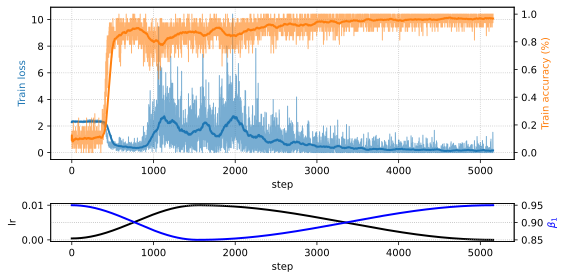

In [29]:
fig, (ax1, ax3) = plt.subplots(2, 1, figsize=(8, 4), gridspec_kw={'height_ratios': [4, 1]})

AX1_COLOR = "C0"
AX2_COLOR = "C1"
ax1.plot(trainer.train_log["loss"], color=AX1_COLOR, linewidth=1, alpha=0.6)
ax1.plot(trainer.train_log["loss_avg"], color=AX1_COLOR, linewidth=2)
ax1.grid(axis="both", linestyle="dotted", alpha=0.8)
ax1.set_xlabel("step")

ax2 = ax1.twinx()
ax2.plot(trainer.train_log["accs"], color=AX2_COLOR, linewidth=1, alpha=0.6)
ax2.plot(trainer.train_log["accs_avg"], color=AX2_COLOR, linewidth=2)

ax1.set_ylabel("Train loss")
ax2.set_ylabel("Train accuracy (%)")
ax1.yaxis.label.set_color(AX1_COLOR)
ax2.yaxis.label.set_color(AX2_COLOR)

ax4 = ax3.twinx()
ax3.plot(scheduler_stats.lr, color="black", label="lr", linewidth=2)
ax4.plot(scheduler_stats.momentum, color="blue", label=r"$\beta_1$", linewidth=2)
ax4.grid(linestyle="dotted")
ax3.set_xlabel("step")
ax3.set_ylabel("lr")
ax4.set_ylabel(r"$\beta_1$")
ax3.yaxis.label.set_color("black")
ax4.yaxis.label.set_color("blue")

fig.tight_layout()


**Figure.** Note peak in train loss as LR increases to `max_lr` set at initialization, and the decreasing noise as the LR decreases at the end of training.
This works similar [our previous](dl/02-optim) **LR finder** which is a parameter-free method for finding a good base `lr`.

The bump in learning rate occurs over a wide duration during training, 
so that the optimizer avoids many sharp minima. 
This allows the network to train with less epochs &mdash; increasing the number of 
epochs increases the exploration time (not just convergence time).

In [5]:
!mkdir ./artifacts/
PATH = "./artifacts/mnist_model.pkl"
torch.save(model.state_dict(), PATH)

mkdir: ./artifacts/: File exists
